In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from experiment_utils import *
from src import *


# SAVE TO RESULTS FILE

In [14]:
FOLDER = "RQ5_DIFF_MODELS"

if not os.path.exists(FOLDER):
    os.makedirs(FOLDER)

In [15]:
def f(df, reader): # Keep only K and KP
    df['TEMP'] = df['other'].apply(reader._get_losses_used)
    df = df[(~df["bias mitigation"].str.contains('FYP VAE')) | df["TEMP"].str.contains('Sensitive KL loss') ]
    df = df[~(df["TEMP"].str.contains("Flipped"))]
    df = df[~(df["TEMP"].str.contains("Latent"))]
    return df.drop(columns=['TEMP'])

### APPENDIX: all meatrics for all models KP, K and baselines

In [16]:
for attr in [["sex"],["race"],["race", "sex"]]:            
    files = [os.path.join("results","RESULTS_"+'_'.join(attr)+".csv")]
    
    reader = ResultsReader(files)    
    
    df = f(reader.get_mean_metrics(), reader)
    mean_df = df.groupby(reader.filterable).mean().reset_index()
    mean_df.to_csv(os.path.join(FOLDER,"MEAN_"+'_'.join(attr)+'.csv'), index=False)
    
    df = f(reader.get_filtered_df(), reader)
    mean_df = df.groupby(reader.filterable).std().reset_index()
    mean_df.to_csv(os.path.join(FOLDER,"STD_"+'_'.join(attr)+'.csv'), index=False)



File 'results\RESULTS_sex.csv' successfully loaded as DataFrame.
File 'results\RESULTS_race.csv' successfully loaded as DataFrame.
File 'results\RESULTS_race_sex.csv' successfully loaded as DataFrame.


### NR OF incr of SF BY MODEL

In [17]:
"""
For all baselines and my relavant losses count of times SF/F1 has been equal or higher than the 
baseline model, separately for each of the 6 ml models used
"""

for attr in [["sex"],["race"],["race", "sex"]]:
    files = [os.path.join("results","RESULTS_"+'_'.join(attr)+".csv")]
    reader = ResultsReader(files)
    reader.change_other_to_losses()

    rel_df = reader.get_relative_metrics()

    metrics_to_use = ["SF"]
    metrics_to_display = [m for m in reader.metrics if metric_has_substring(m,metrics_to_use )]
    metrics_to_display = ['[SF] Statistical Parity Subgroup Fairness']
    
    for data in ["Adult", "Compas", "Default"]:        
        df = f(rel_df[(rel_df["data"].str.contains(data))], reader)
        
        if df.shape[0] > 0: # in case some dataset has no results for some metrics
            counts_total = df[(df["bias mitigation"].str.contains('No'))].groupby(["bias mitigation", "other"]).count()[metrics_to_display]
            result = df.groupby(["bias mitigation", "other", "ML method"])[metrics_to_display].apply(lambda x: (x >= 0).sum()).reset_index()
            results = pd.concat([result, counts_total])
            
            for i, metric in enumerate(metrics_to_display):
                pivot_df = results.pivot_table(index=["bias mitigation", "other"], columns='ML method', values=metric, aggfunc='sum', fill_value=0)            
                pivot_df.to_csv(os.path.join(FOLDER,metrics_to_use[i]+'_PER_MODEL_nr_incr_'+data+'_'+"_".join(attr)+'.csv'), index=True,  index_label=["bias mitigation", "other"])

File 'results\RESULTS_sex.csv' successfully loaded as DataFrame.
File 'results\RESULTS_race.csv' successfully loaded as DataFrame.
File 'results\RESULTS_race_sex.csv' successfully loaded as DataFrame.


# VIS

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from experiment_utils import *
from src import *


In [7]:
size = 3

In [8]:
def f(df, reader, ml_method='nn'): # Keep only K and KP
    df = df[(df["ML method"].str.contains(ml_method))]
    df['TEMP'] = df['other'].apply(reader._get_losses_used)
    df = df[(~df["bias mitigation"].str.contains('FYP VAE')) | df["TEMP"].str.contains('Sensitive KL loss') ]
    df = df[~(df["TEMP"].str.contains("Flipped"))]
    df = df[~(df["TEMP"].str.contains("Latent"))]
    return df.drop(columns=['TEMP'])

In [9]:
files, datasets, titles = get_all_single_attr_files()

In [10]:
models = [
    ["NN","nn keras"],
    ["SV","SupportVectorClassifier"],
    ["LR","LogisticRegression"],
    ["NB","NaiveBayes"],
    ["DT","DecisionTreeRegressor"],
    ["RF","RandomForestClassifier"],
]

File 'results\MAIN_defualt_sex.csv' successfully loaded as DataFrame.
metrics to display: ['sex|[SF] Statistical Parity Subgroup Fairness for One Attribute', '[SF] Statistical Parity Subgroup Fairness', '[SF] Statistical Parity Subgroup Fairness if 0 was the positive label'] f1score
File 'results\RESULTS_race.csv' successfully loaded as DataFrame.
metrics to display: ['race|[SF] Statistical Parity Subgroup Fairness for One Attribute', '[SF] Statistical Parity Subgroup Fairness', '[SF] Statistical Parity Subgroup Fairness if 0 was the positive label'] f1score
File 'results\RESULTS_sex.csv' successfully loaded as DataFrame.
metrics to display: ['sex|[SF] Statistical Parity Subgroup Fairness for One Attribute', '[SF] Statistical Parity Subgroup Fairness', '[SF] Statistical Parity Subgroup Fairness if 0 was the positive label'] f1score
File 'results\RESULTS_race.csv' successfully loaded as DataFrame.
metrics to display: ['race|[SF] Statistical Parity Subgroup Fairness for One Attribute', '

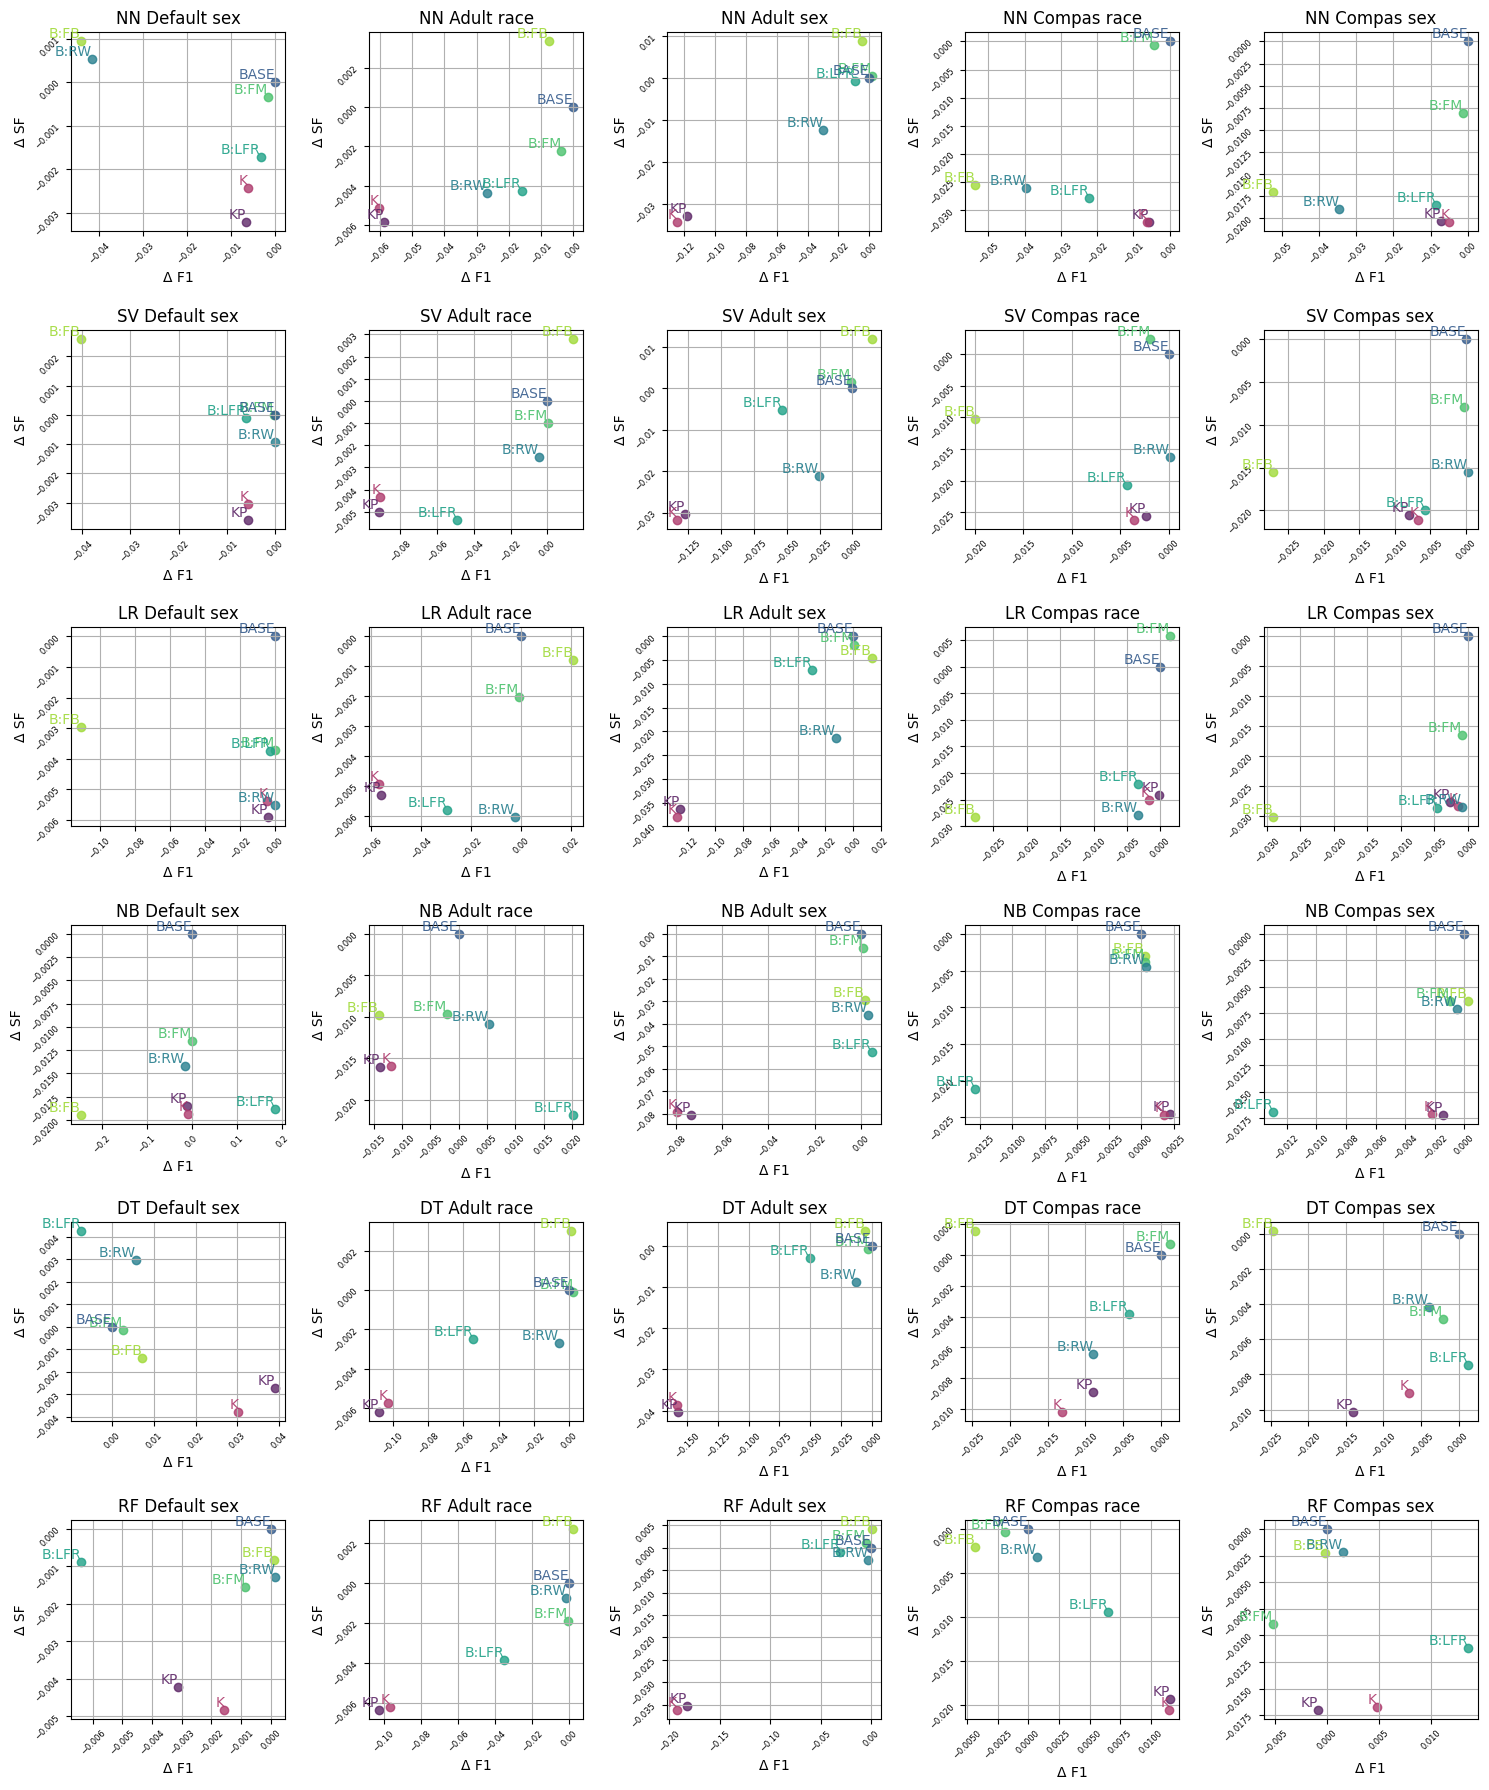

In [11]:
F, axes = plt.subplots(6, 5, figsize=(size*(5), size*6))
for j in range(6):
    model_short, model_name = models[j]
    fltr = lambda df, reader: f(df, reader, model_name)
    for i in range(5):
        plot_one_run(fltr, files[i], datasets[i], axes[j][i])
        axes[j][i].set_title(model_short+' '+titles[i])
        axes[j][i].set_ylabel("Δ SF") # comment out to make sure 
        axes[j][i].set_xlabel("Δ F1")
        
plt.rc('axes', axisbelow=True)
plt.tight_layout()
plt.show()
# TODO: maybe standardise the sf and f1 scales

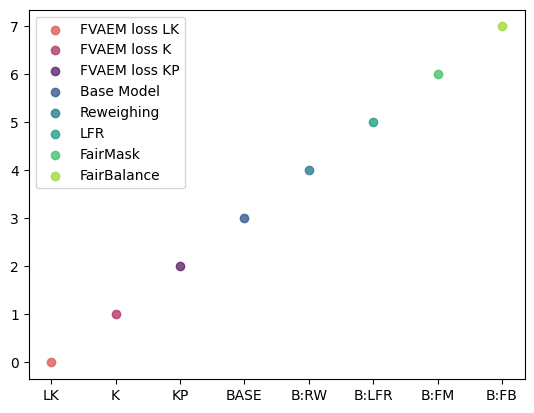

In [12]:
# LEGEND!
grapher = ResultsGrapher(None)
labels  = ["LK","K","KP",'BASE',"B:RW","B:LFR","B:FM","B:FB"]
for i, l in enumerate(labels):
    plt.scatter(
            l,
            i,
            label=grapher._get_legend_text(l, l),
            color=grapher.get_color(l),
            alpha=0.8,
        )
plt.legend()
plt.show()